# T03: Identificação área de código de barras
Disciplina: Processamento Digital de Imagens

Aluno: Gabriel Finger Conte

### Preparando o Terreno

In [1]:
# Importando Bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt

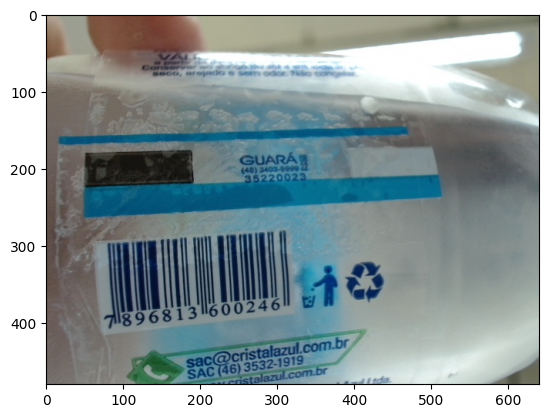

In [2]:
# Importando a imagem a ser analisada
img = cv2.imread("barcode2.jpg")
# Convertendo para RGB
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Exibindo a imagem importada
plt.imshow(img)
plt.show()


### Definindo o algoritmo para obter a região do código de barras
Obs: Os valores padrões foram definidos de maneira empírica, de modo a obter um resultado interessante para a imagem base fornecida.

In [3]:
def vbarcode_extractor(rgb_img,EXPANDED_REGION=False,VLK_SIZE = 3, VLK_PW = 2, VLW_NW = -3, BIN_LIM = 128, HDK_SIZE = 7, DIL_ITERATIONS = 7, EK_SHAPE=(4,12), ERO_ITERATIONS = 6, SHOW_STEPS = False):
    """
    Processa uma imagem para detectar e extrair a região de um código de barras vertical. A função aplica uma série de operações de
    binarização, filtragem, dilatação e erosão para identificar a área onde o código de barras está presente.

    Args:
        rgb_img (np.ndarray): Matriz representando a imagem de entrada, esperada em RGB, onde cada pixel representa um valor de intensidade.
        EXPANDED_REGION (bool, optional): Ser verdadeira, expande a dilatação final para capturar bordas adicionais. Defaults para False.
        VLK_SIZE (int, optional): Tamanho do kernel vertical para detectar linhas verticais. Defaults para 3.
        VLK_PW (int, optional): Peso positivo do kernel de detecção vertical. Defaults para 2.
        VLW_NW (int, optional): Peso negativo do kernel de detecção vertical. Defaults para -3.
        BIN_LIM (int, optional): Limite para binarização de imagens. Defaults para 128.
        HDK_SIZE (int, optional): Tamanho do kernel horizontal para dilatação. Defaults para 7.
        DIL_ITERATIONS (int, optional): Número de iterações para a operação de dilatação. Defaults para 7.
        EK_SHAPE (tuple, optional): Formato do kernel de erosão, preferencialmente retangular para corresponder ao formato típico de códigos de barras. Defaults para (4, 12).
        ERO_ITERATIONS (int, optional): Número de iterações para a operação de erosão. Defaults para 6.
        SHOW_STEPS (bool, optional): Se verdadeira, exibe as etapas do tratamento da imagem para obter a máscara. Defaults para False.
        
    Returns:
        tuple:
            - barcode_region_img (np.ndarray): Imagem segmentada contendo a região do código de barras.
            - barcode_mask (np.ndarray): Máscara binária da área do código de barras na imagem original.
    """
    
    def binarize_img(img,binarization_limit):
        """
        Binariza uma imagem com base em um limite especificado. Todos os pixels com intensidade acima do limite
        serão ajustados para o valor máximo (255), enquanto aqueles abaixo do limite serão ajustados para o valor mínimo (0).

        Args:
            img (np.ndarray): Uma matriz representando uma imagem em escala de cinza, onde cada elemento corresponde à intensidade de um pixel.
                O `dtype` esperado para a matriz é `np.uint8` ou similar, com valores de pixel entre 0 e 255.
            binarization_limit (int): O valor limite para binarização. Pixels com valor maior ou igual a esse limite serão ajustados para 255,
                enquanto pixels abaixo desse limite serão ajustados para 0.

        Returns:
            np.ndarray: Uma nova matriz representando a imagem binarizada.
        """
        bin_img = img.copy()
        bin_img[bin_img > binarization_limit] = 255
        bin_img[bin_img < binarization_limit] = 0
        return bin_img
    
    def show_steps():
        """
        Exibe em múltiplos subgráficos os passos para a obtenção da máscara de um código de barras.

        Returns:
            None: A função não retorna valores, mas exibe uma janela com a visualização dos passos.
        """
        plt.figure(figsize=(20, 10))
        plt.suptitle("vbarcode_extractor: Passos para obtenção da máscara")

        plt.subplot(3, 3, 1)
        plt.imshow(filtered_img)
        plt.title("Passo 1: Filtro de Linhas Verticais")

        plt.subplot(3, 3, 2)
        plt.imshow(binarized_filt_img, cmap="gray")
        plt.title("Passo 2: Binarização em Escala de Cinza")

        plt.subplot(3, 3, 3)
        plt.imshow(dilated_img, cmap="gray")
        plt.title("Passo 3: Dilatação")

        plt.subplot(3, 3, 4)
        plt.imshow(eroded_img, cmap="gray")
        plt.title("Passo 4: Erosão")

        plt.subplot(3, 3, 5)
        plt.imshow(dil_erod, cmap="gray")
        plt.title("Passo 5: Dilatação de Erosão Binarizada")

        plt.subplot(3, 3, 6)
        plt.imshow(barcode_mask, cmap="gray")
        plt.title("Passo 6: Seleção da Segunda Maior Área")

        plt.show()
    
    # Gera o kernel para encontrar as linhas verticais
    vertical_lines_kernel = np.vstack((
        np.ones(VLK_SIZE) * 
        VLK_PW, np.zeros(VLK_SIZE), 
        np.ones(VLK_SIZE) * VLW_NW
        )).T

    # Aplica o filtro das linhas verticais na imagem
    filtered_img = cv2.filter2D(src=rgb_img, ddepth=-1, kernel=vertical_lines_kernel)

    # Converte a imagem filtrada com as linhas verticais para a escala de cinza
    filtered_img_gray = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)

    # Transforma a imagem em uma máscara binária para as linhas verticais
    binarized_filt_img = binarize_img(filtered_img_gray, BIN_LIM)

    # Constrói o kernel para dilatar a máscara
    dilatation_kernel = np.ones((1, HDK_SIZE))

    # Dilata a máscara das linhas verticais
    dilated_img = cv2.dilate(src=binarized_filt_img, kernel=dilatation_kernel, iterations=DIL_ITERATIONS)

    # Constrói o kernel para erosão da máscara (retângular preferencialmente devido ao formato padrão de códigos de barra)
    erosion_kernel = np.ones(EK_SHAPE, np.uint8)

    # Erode a máscara, removendo componentes indesejados
    eroded_img = cv2.erode(src=dilated_img, kernel=erosion_kernel, iterations=ERO_ITERATIONS)
    
    # Binariza a máscara erodida
    binarized_eroded_img = binarize_img(eroded_img, BIN_LIM)

    # Dilata a máscara para pegar as laterais que foram erodidas
    dil_erod = cv2.dilate(src=binarized_eroded_img, kernel=dilatation_kernel, iterations=DIL_ITERATIONS)
    
    # Caso tenha sido erodido muito as laterais do código, com essa opção dilata-se uma segunda vez
    if EXPANDED_REGION:
        dil_erod = cv2.dilate(src=dil_erod, kernel=dilatation_kernel, iterations=DIL_ITERATIONS)

    # Binariza pela última vez a máscara
    bin_dil_erod = binarize_img(dil_erod, BIN_LIM)

    # Verifica os componentes conectados existentes
    _, labels = cv2.connectedComponents(bin_dil_erod) 
    
    # Verifica a área de cada componente conectado
    cc_areas = np.bincount(labels.flatten()) 
    
    # Encontra a segunda maior região (Espera-se que a segunda seja o código de barras, depois do fundo)
    second_major_area_label = np.argsort(cc_areas)[-2] 

    # Determina a máscara final, apenas com a segunda maior região
    barcode_mask = bin_dil_erod.copy()
    barcode_mask[labels != second_major_area_label] = 0

    # Seleciona a região da imagem que tem o código de barras
    barcode_region_img = cv2.bitwise_and(rgb_img, rgb_img, mask=barcode_mask)
    
    # Exibindo as etapas do processo
    if SHOW_STEPS:
        show_steps()
    
    return barcode_region_img,barcode_mask


### Testando o Algoritmo

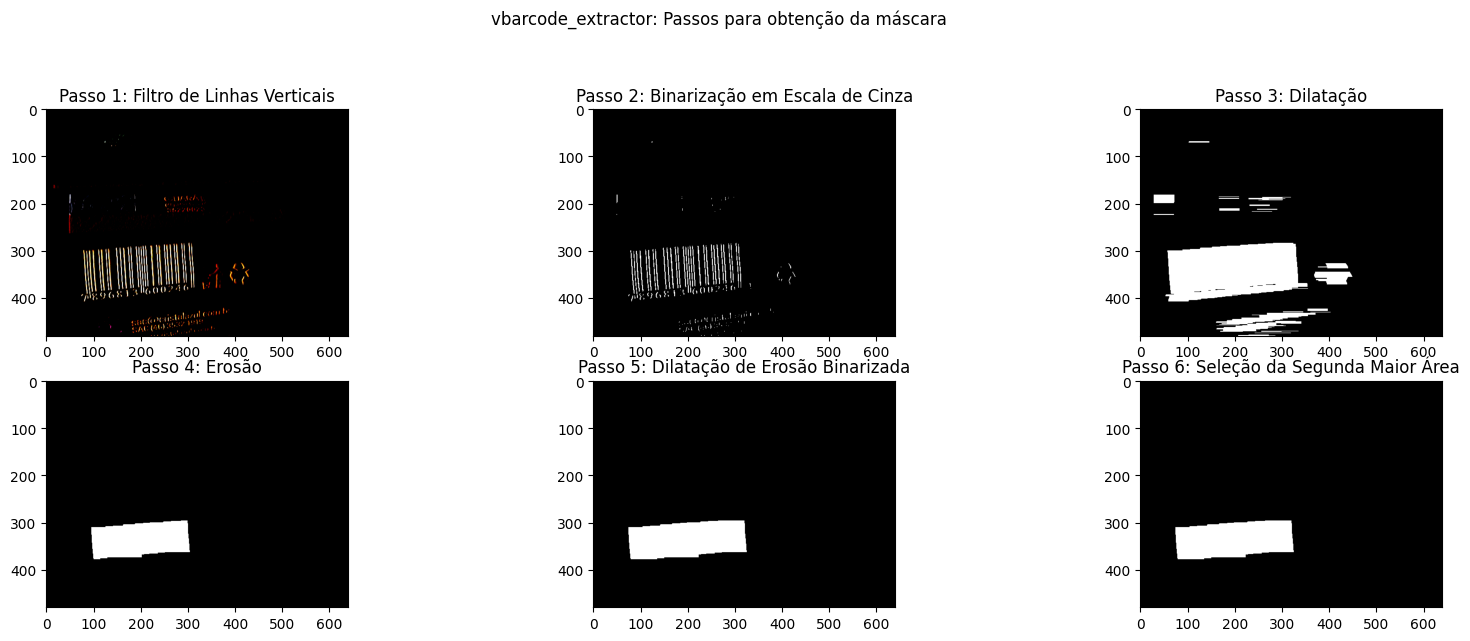

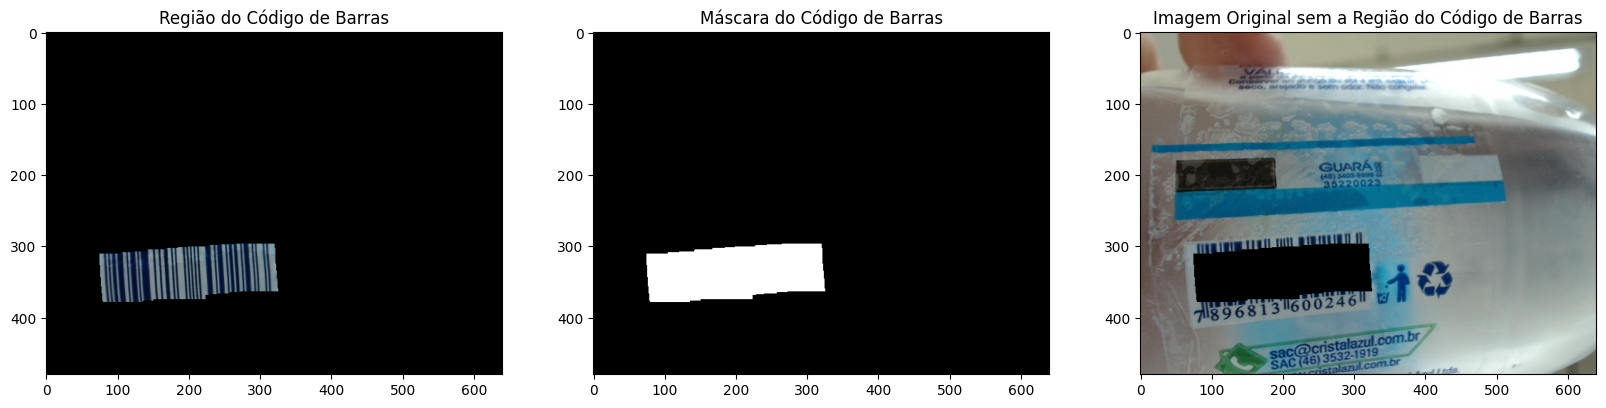

In [4]:
# Extrai a região do código de barras e sua máscara binária
region, mask = vbarcode_extractor(img,SHOW_STEPS=True)

# Mostra a região da imagem, a máscara e a imagem sem a região delimitada
plt.figure(figsize=(20, 10))
# Subplot 1: Exibe a região do código de barras detectada
plt.subplot(1, 3, 1)
plt.imshow(region)
plt.title("Região do Código de Barras")
# Subplot 2: Exibe a máscara binária da área do código de barras
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Máscara do Código de Barras")
# Subplot 3: Exibe a imagem original com a região do código de barras removida
plt.subplot(1, 3, 3)
plt.imshow(cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask)))
plt.title("Imagem Original sem a Região do Código de Barras")
plt.show()